# pip install

In [1]:
pip install tflearn

     |████████████████████████████████| 112kB 7.7MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=29c69d678485d72f710fe71c1bdf2d5fe6d28990051e0b8722e5da0a14b39987
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [2]:
import tensorflow as tf
from tflearn import DNN
import time
import numpy as np
import argparse
import dlib
import cv2
import os
from skimage.feature import hog
from numpy import zeros, newaxis
from google.colab.patches import cv2_imshow
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.merge_ops import merge_outputs, merge
from tflearn.layers.normalization import local_response_normalization, batch_normalization
from tflearn.layers.estimator import regression 
from tflearn.optimizers import Momentum, Adam
from google.colab.patches import cv2_imshow

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def load_model():
    model = None
    with tf.Graph().as_default():
        print( "loading pretrained model...")
        network = build_model()
        model = DNN(network)
        if os.path.isfile(TRAINING.save_model_path):
            model.load(TRAINING.save_model_path)
        else:
            print( "Error: file '{}' not found".format(TRAINING.save_model_path))
    return model

def get_landmarks(image, rects, predictor):
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, NETWORK.input_size, window_step):
        for x in range(0, NETWORK.input_size, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

# Parameters

In [6]:
ls 'drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG'

PrivateTest/  PublicTest/  Training/


In [11]:
ls 'drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG_best_model'

checkpoint       saved_model.bin.data-00000-of-00001
saved_model.bin  saved_model.bin.index


In [12]:
class Dataset:
    name = 'Fer2013'
    train_folder = 'drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG/Training'
    validation_folder = 'drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG/PublicTest'
    test_folder = 'drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG/PrivateTest'
    shape_predictor_path='drive/MyDrive/AIHealthcare/facial_expression_recognition_using_cnn/shape_predictor_68_face_landmarks.dat'
    trunc_trainset_to = -1  # put the number of train images to use (-1 = all images of the train set)
    trunc_validationset_to = -1
    trunc_testset_to = -1

class Network:
    model = 'B'
    input_size = 48
    output_size = 7
    activation = 'relu'
    loss = 'categorical_crossentropy'
    use_landmarks = True
    use_hog_and_landmarks = True
    use_hog_sliding_window_and_landmarks = False
    use_batchnorm_after_conv_layers = True
    use_batchnorm_after_fully_connected_layers = False

class Hyperparams:
    keep_prob = 0.956   # dropout = 1 - keep_prob
    learning_rate = 0.016
    learning_rate_decay = 0.864
    decay_step = 50
    optimizer = 'momentum'  # {'momentum', 'adam', 'rmsprop', 'adagrad', 'adadelta'}
    optimizer_param = 0.95   # momentum value for Momentum optimizer, or beta1 value for Adam

class Training:
    batch_size = 128
    epochs = 13
    snapshot_step = 500
    vizualize = True
    logs_dir = "logs"
    checkpoint_dir = "checkpoints/chk"
    best_checkpoint_path = "checkpoints/best/"
    max_checkpoints = 1
    checkpoint_frequency = 1.0 # in hours
    save_model = True
    save_model_path = "drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG_best_model/saved_model.bin"

class VideoPredictor:
    emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    print_emotions = False
    camera_source = 0
    face_detection_classifier = "lbpcascade_frontalface.xml"
    show_confidence = False
    time_to_wait_between_predictions = 0.5

class OptimizerSearchSpace:
    learning_rate = {'min': 0.00001, 'max': 0.1}
    learning_rate_decay = {'min': 0.5, 'max': 0.99}
    optimizer = ['momentum']   # ['momentum', 'adam', 'rmsprop', 'adagrad', 'adadelta']
    optimizer_param = {'min': 0.5, 'max': 0.99}
    keep_prob = {'min': 0.7, 'max': 0.99}

def make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

DATASET = Dataset()
NETWORK = Network()
TRAINING = Training()
HYPERPARAMS = Hyperparams()
VIDEO_PREDICTOR = VideoPredictor()
OPTIMIZER = OptimizerSearchSpace()

make_dir(TRAINING.logs_dir)
make_dir(TRAINING.checkpoint_dir)

# Model

In [13]:
def build_model(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
    learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob,
    learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step):

    if NETWORK.model == 'A':
        return build_modelA(optimizer, optimizer_param, learning_rate, keep_prob, learning_rate_decay, decay_step)
    elif NETWORK.model == 'B':
        return build_modelB(optimizer, optimizer_param, learning_rate, keep_prob, learning_rate_decay, decay_step)
    else:
        print( "ERROR: no model " + str(NETWORK.model))
        exit()

def build_modelB(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
    learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob,
    learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step):

    images_network = input_data(shape=[None, NETWORK.input_size, NETWORK.input_size, 1], name='input1')
    images_network = conv_2d(images_network, 64, 3, activation=NETWORK.activation)
    #images_network = local_response_normalization(images_network)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 128, 3, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 256, 3, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = dropout(images_network, keep_prob=keep_prob)
    images_network = fully_connected(images_network, 4096, activation=NETWORK.activation)
    images_network = dropout(images_network, keep_prob=keep_prob)
    images_network = fully_connected(images_network, 1024, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_fully_connected_layers:
        images_network = batch_normalization(images_network)

    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks:
        if NETWORK.use_hog_sliding_window_and_landmarks:
            landmarks_network = input_data(shape=[None, 2728], name='input2')
        elif NETWORK.use_hog_and_landmarks:
            landmarks_network = input_data(shape=[None, 208], name='input2')
        else:
            landmarks_network = input_data(shape=[None, 68, 2], name='input2')
        landmarks_network = fully_connected(landmarks_network, 1024, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        landmarks_network = fully_connected(landmarks_network, 128, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        images_network = fully_connected(images_network, 128, activation=NETWORK.activation)
        network = merge([images_network, landmarks_network], 'concat', axis=1)
    else:
        network = images_network
    network = fully_connected(network, NETWORK.output_size, activation='softmax')

    if optimizer == 'momentum':
        optimizer = Momentum(learning_rate=learning_rate, momentum=optimizer_param, 
                    lr_decay=learning_rate_decay, decay_step=decay_step)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate, beta1=optimizer_param, beta2=learning_rate_decay)
    else:
        print( "Unknown optimizer: {}".format(optimizer))
    network = regression(network, optimizer=optimizer, loss=NETWORK.loss, learning_rate=learning_rate, name='output')

    return network

def build_modelA(optimizer=HYPERPARAMS.optimizer, optimizer_param=HYPERPARAMS.optimizer_param, 
    learning_rate=HYPERPARAMS.learning_rate, keep_prob=HYPERPARAMS.keep_prob,
    learning_rate_decay=HYPERPARAMS.learning_rate_decay, decay_step=HYPERPARAMS.decay_step):

    images_network = input_data(shape=[None, NETWORK.input_size, NETWORK.input_size, 1], name='input1')
    images_network = conv_2d(images_network, 64, 5, activation=NETWORK.activation)
    #images_network = local_response_normalization(images_network)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 64, 5, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = max_pool_2d(images_network, 3, strides = 2)
    images_network = conv_2d(images_network, 128, 4, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_conv_layers:
        images_network = batch_normalization(images_network)
    images_network = dropout(images_network, keep_prob=keep_prob)
    images_network = fully_connected(images_network, 1024, activation=NETWORK.activation)
    if NETWORK.use_batchnorm_after_fully_connected_layers:
        images_network = batch_normalization(images_network)

    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks:
        if NETWORK.use_hog_sliding_window_and_landmarks:
            landmarks_network = input_data(shape=[None, 2728], name='input2')
        elif NETWORK.use_hog_and_landmarks:
            landmarks_network = input_data(shape=[None, 208], name='input2')
        else:
            landmarks_network = input_data(shape=[None, 68, 2], name='input2')
        landmarks_network = fully_connected(landmarks_network, 1024, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        landmarks_network = fully_connected(landmarks_network, 40, activation=NETWORK.activation)
        if NETWORK.use_batchnorm_after_fully_connected_layers:
            landmarks_network = batch_normalization(landmarks_network)
        images_network = fully_connected(images_network, 40, activation=NETWORK.activation)
        network = merge([images_network, landmarks_network], 'concat', axis=1)
    else:
        network = images_network
    network = fully_connected(network, NETWORK.output_size, activation='softmax')

    if optimizer == 'momentum':
        optimizer = Momentum(learning_rate=learning_rate, momentum=optimizer_param, 
                    lr_decay=learning_rate_decay, decay_step=decay_step)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate, beta1=optimizer_param, beta2=learning_rate_decay)
    else:
        print( "Unknown optimizer: {}".format(optimizer))
    network = regression(network, optimizer=optimizer, loss=NETWORK.loss, learning_rate=learning_rate, name='output')

    return network

# inference

loading pretrained model...
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/AIHealthcare/Facial_expressions_model_data/LANDMARKS_HOG_best_model/saved_model.bin


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Prediction: Surprise (confidence: 62.0%)
time: 32.5 sec


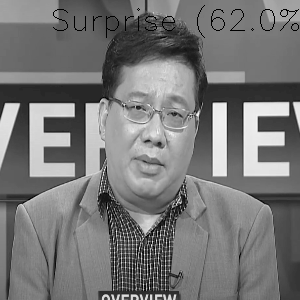

In [14]:
window_size = 24
window_step = 6

def predict(image, model, shape_predictor=None):
    image = cv2.resize(image,(NETWORK.input_size,NETWORK.input_size))
    
    # get landmarks
    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks or NETWORK.use_hog_sliding_window_and_landmarks:
        face_rects = [dlib.rectangle(left=0, top=0, right=NETWORK.input_size, bottom=NETWORK.input_size)]
        face_landmarks = np.array([get_landmarks(image, face_rects, shape_predictor)])
        features = face_landmarks
        
        if NETWORK.use_hog_sliding_window_and_landmarks: 
            hog_features = sliding_hog_windows(image)
            hog_features = np.asarray(hog_features)
            face_landmarks = face_landmarks.flatten()
            features = np.concatenate((face_landmarks, hog_features))
        elif NETWORK.use_hog_and_landmarks:
            hog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                    cells_per_block=(1, 1), visualize=True)
            hog_features = np.asarray(hog_features)
            face_landmarks = face_landmarks.flatten()
            features = np.concatenate((face_landmarks, hog_features))


        image = image[newaxis,:, : ]
        tensor_image = image.reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])

        # predicted_label = model.predict([tensor_image, features])
        predicted_label = model.predict([tensor_image, features.reshape((1, -1))])
        return get_emotion(predicted_label[0])
    else:
        tensor_image = image.reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
        predicted_label = model.predict(tensor_image)
        return get_emotion(predicted_label[0])
    return None

def get_emotion(label):
    if VIDEO_PREDICTOR.print_emotions:
        print( "- Angry: {0:.1f}%\n- Happy: {1:.1f}%\n- Sad: {2:.1f}%\n- Surprise: {3:.1f}%\n- Neutral: {4:.1f}%".format(
                label[0]*100, label[1]*100, label[2]*100, label[3]*100, label[4]*100))
    label = label.tolist()
    return VIDEO_PREDICTOR.emotions[label.index(max(label))], max(label)

model = load_model()
image = cv2.imread('drive/MyDrive/AIHealthcare/facial_expression_recognition_using_cnn/img/sad.png', 0)
shape_predictor = dlib.shape_predictor(DATASET.shape_predictor_path)
start_time = time.time()
emotion, confidence = predict(image, model, shape_predictor)
total_time = time.time() - start_time
print( "Prediction: {0} (confidence: {1:.1f}%)".format(emotion, confidence*100))
print( "time: {0:.1f} sec".format(total_time))
image = cv2.resize(image,(300,300))
TEXT_COLOR = (0, 255, 0)
text = "{0} ({1:.1f}%)".format(emotion, confidence*100)
cv2.putText(image, text,(50,30),cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 1)
cv2_imshow(image)

In [ ]:
# !python predict-from-video.py